# import our numerical workhorses

In [1]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [2]:
#define log posterior (modified from class notes)
def log_posterior_delta_gamma(p):
    """
    Log Posterior probability distribution for delta and gamma.
    
    Input is arrays delta and gamma.  Returns a 2D array for various 
    values of gamma.
    """
    delta, gamma = p
    n_r1=9
    n_1=35
    n_r2=33
    n_2=36
    # Make 2D versions of delta and gamma
    dd, gg = np.meshgrid(delta, gamma)

    # Initialize output array
    out = np.empty_like(dd)
    # Populate np.inf values based on outlawed deltas and gammas

    out[abs(dd) > 1] = -np.inf
    out[gg < 0] = -np.inf
    out[gg > 2] = -np.inf
    out[(gg <= abs(dd))] = -np.inf
    out[(gg >= (2-abs(dd)))] = -np.inf

    # Get indices with nonzero values
    inds = (out != -np.inf)
    # Compute log probability
    log_P = scipy.special.gammaln(n_1 + 2) - scipy.special.gammaln(n_r1 + 1) \
            + scipy.special.gammaln(n_2 + 2) - scipy.special.gammaln(n_r2 + 1) \
            - scipy.special.gammaln(n_1 - n_r1 + 1) \
            - scipy.special.gammaln(n_2 - n_r2 + 1) -np.log(2) \
            + n_r1 * np.log((gg[inds] - dd[inds]) / 2) \
            + n_r2 * np.log((gg[inds] + dd[inds]) / 2) \
            + (n_1 - n_r1) * np.log(1 - (gg[inds] - dd[inds]) / 2) \
            + (n_2 - n_r2) * np.log(1 - (gg[inds] + dd[inds]) / 2)
            
    # Populate non-infinite values and return
    out[inds] = log_P
    
    return out

In [3]:
n_dim = 2        # number of parameters in the model (delta and gamma)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in
np.random.seed(42)


In [4]:
p0 = np.empty((n_walkers, n_dim))

p0[:,0] = np.random.uniform(-1,1, n_walkers)            # delta-uniform selection from -1 to 1
#p0[:,1] = np.random.uniform( abs(np.min(p0[:,0])), abs(np.max(p0[:,0])), n_walkers)
p0[:,1] = np.random.uniform( 0, 2, n_walkers)

In [5]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_delta_gamma)

In [6]:
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [7]:
_ = sampler.run_mcmc(pos, n_steps)

In [8]:
print(sampler.chain.shape)
print(sampler.flatchain.shape)

(50, 5000, 2)
(250000, 2)


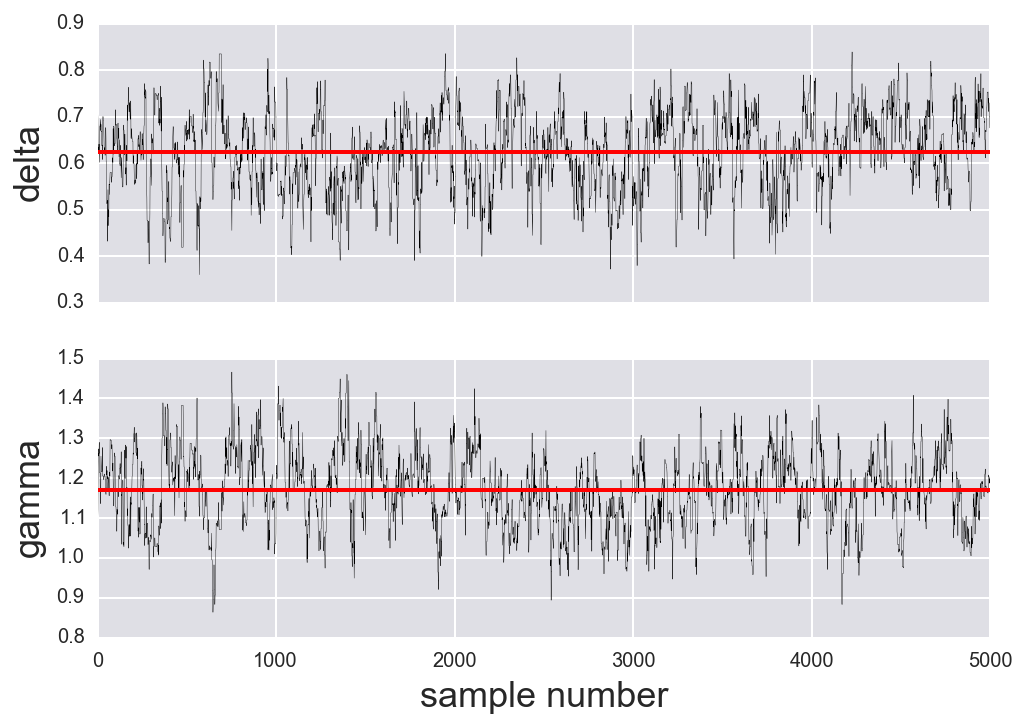

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in [0, 1]:
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('delta')
ax[1].set_ylabel('gamma')

In [ ]:
sampler.chain[0,:,0].std()

In [ ]:
sampler.chain[0,:,1]

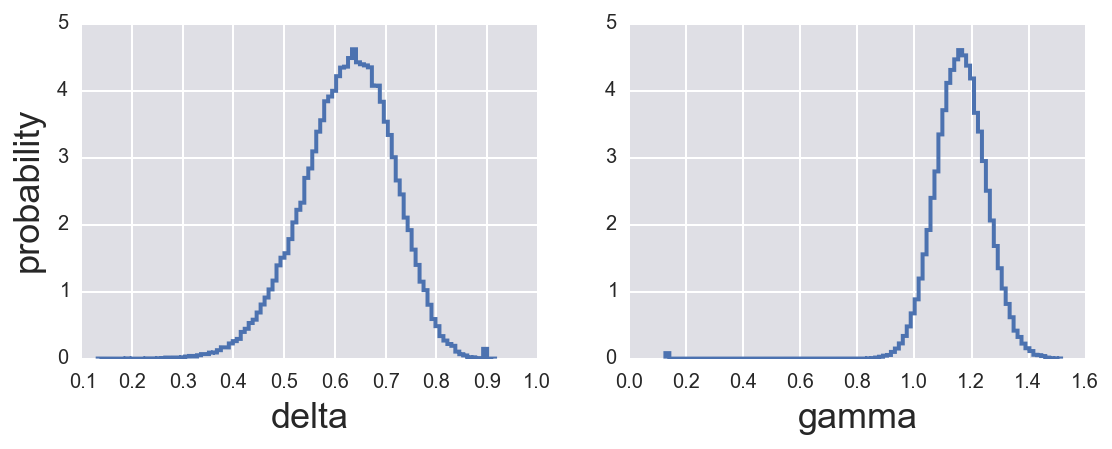

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i in [0, 1]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(sampler.flatchain[:,i], bins=100, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel('delta')
ax[1].set_xlabel('gamma')
ax[0].set_ylabel('probability')

In [12]:
df2 = pd.read_csv('data/reeves_gradient_width_various_methods.csv', comment='#', header=[0,1])
TidyData2 = pd.melt(df2)
TidyData2.columns = ['Genotype', 'VisualizationMethod', 'GradientWidth']
TidyData2 = TidyData2.dropna().reset_index(drop=True)

# Rename the anti-Dorsal method to distinguish between Venus and GFP fusion genotypes, otherwise our grouped boxplot 
# has a weird gap between anti-Dorsal and the other methods under the GFP fusion genotype
inds = (TidyData2.Genotype=='dl1/+; dl-gfp/+')
gfp = TidyData2[inds].replace(to_replace={'anti-Dorsal':'anti-Dorsal (dl1/+; dl-gfp/+)'})
inds2 = (TidyData2.Genotype !='dl1/+; dl-gfp/+') 
TidyData2 = pd.concat((TidyData2[inds2], gfp))

# For the sake of convenience for plotting, create new DataFrame with only the samples of interest
inds = (TidyData2.Genotype=='wt') & (TidyData2.VisualizationMethod=='cross-sections')
inds2 = (TidyData2.Genotype=='dl1/+; dl-venus/+') & (TidyData2.VisualizationMethod=='anti-Dorsal')
WtDorsal = pd.concat((TidyData2[inds], TidyData2[inds2]))


In [13]:
WtDorsal

,Genotype,VisualizationMethod,GradientWidth
24,wt,cross-sections,0.1327
25,wt,cross-sections,0.1457
26,wt,cross-sections,0.1447
27,wt,cross-sections,0.1282
28,wt,cross-sections,0.1487
29,wt,cross-sections,0.1203
30,wt,cross-sections,0.1315
31,wt,cross-sections,0.1463
32,wt,cross-sections,0.1458
33,wt,cross-sections,0.1402


In [14]:
def fluor(c, A, B, s):
    """
    Theoretical model for fluorescence intensity (i.e. Dorsal expression) as a function of position c
    along the DV coordinate axis. 
    """
    return A * np.exp(-(c**2)/(2 * s**2)) + B

def log_post(p, c, f):
    """
    Compute log of posterior for single set of parameters.
    p[0] = A
    p[1] = B
    p[2] = s
    """
    # Unpack parameters
    A, B, s = p
    
    # Theoretical spindle length
    f_theor = fluor(c, A, B, s)
    
    return -len(c) / 2 * np.log(np.sum((f - f_theor)**2))

\begin{align}
P(µ \mid µ_1,µ_2,\sigma_1,\sigma_2,I) = P (everything \mid µ,I) P()/P()
\end{align}